DXG

In [1]:
import pandas as pd
import numpy as np
# from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import datetime
from sklearn.preprocessing import MinMaxScaler

In [2]:
def preprocess_stock_data(csv_file_path):
    # Load data from CSV file
    data = pd.read_csv(csv_file_path)
    data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
    data.set_index('Date', inplace=True)
    
    # Fill missing dates
    full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
    data = data.reindex(full_date_range)
    data = data.ffill()
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Date'}, inplace=True)
    
    # Convert volume from string to number
    def convert_volume_to_number(volume_str):
        if isinstance(volume_str, float) and np.isnan(volume_str):
            return np.nan
        if volume_str[-1] == 'K':
            return int(float(volume_str[:-1]) * 1000)
        elif volume_str[-1] == 'M':
            return int(float(volume_str[:-1]) * 1000000)
        elif volume_str[-1] == 'B':
            return int(float(volume_str[:-1]) * 1000000000)
        else:
            return int(volume_str)
    
    # Apply convert_volume_to_number function to Volume column
    data["Volume"] = data["Volume"].apply(convert_volume_to_number)
    
    # Convert change % from string to number
    def convert_change_to_number(change_str):
        if isinstance(change_str, float) and np.isnan(change_str):
            return np.nan
        new_change = float(change_str.strip('%')) / 100
        return new_change

    # Apply convert_change_to_number function to Change % column
    data["Change %"] = data["Change %"].apply(convert_change_to_number)
    
    # Function to convert string to number
    def convert_str_to_number(str_value):
        if isinstance(str_value, float) and np.isnan(str_value):
            return np.nan
        return float(str_value.replace(',', ''))
    
    # Apply convert_str_to_number function to Close, Open, High, Low columns
    data['Close'] = data['Close'].apply(convert_str_to_number)
    data['Open'] = data['Open'].apply(convert_str_to_number)
    data['High'] = data['High'].apply(convert_str_to_number)
    data['Low'] = data['Low'].apply(convert_str_to_number)
    
    data = data.sort_values('Date', ascending=True)
    return data

In [3]:
# 2. Đọc file csv và gắng index với giá Close
dxg = preprocess_stock_data('../../DATASET/DXG.csv')
dxg.set_index('Date',inplace=True)
dxg1 = dxg['Close']
dxg1

qcg = preprocess_stock_data('../../DATASET/QCG.csv')
qcg.set_index('Date',inplace=True)
qcg1 = qcg['Close']
qcg1

vhm = preprocess_stock_data('../../DATASET/VHM.csv')
vhm.set_index('Date',inplace=True)
vhm1 = vhm['Close']
vhm1

Date
2019-03-01    68421.0
2019-03-02    68421.0
2019-03-03    68421.0
2019-03-04    70075.0
2019-03-05    68421.0
               ...   
2024-05-27    39800.0
2024-05-28    39950.0
2024-05-29    39450.0
2024-05-30    39000.0
2024-05-31    38850.0
Name: Close, Length: 1919, dtype: float64

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))

dxg1=scaler.fit_transform(np.array(dxg1).reshape(-1,1))
qcg1=scaler.fit_transform(np.array(qcg1).reshape(-1,1))
vhm1=scaler.fit_transform(np.array(vhm1).reshape(-1,1))

In [5]:
# 4. Chia train test
#DXG
dxg_train_size = int(0.9 * len(dxg1))
dxg_test_size = len(dxg1) - dxg_train_size 
dxg_train_data = dxg1[:dxg_train_size]
dxg_test_data = dxg1[dxg_train_size:dxg_train_size+dxg_test_size]



#QCG
qcg_train_size = int(0.9 * len(qcg1))
qcg_test_size = len(qcg1) - qcg_train_size 
qcg_train_data = qcg1[:qcg_train_size]
qcg_test_data = qcg1[qcg_train_size:qcg_train_size+qcg_test_size]


#VHM
vhm_train_size = int(0.9 * len(vhm1))
vhm_test_size = len(vhm1) - vhm_train_size 
vhm_train_data = vhm1[:vhm_train_size]
vhm_test_data = vhm1[vhm_train_size:vhm_train_size+vhm_test_size]


In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
#DXG
time_step = 100
dxg_X_train, dxg_y_train = create_dataset(dxg_train_data, time_step)
dxg_X_test, dxg_ytest = create_dataset(dxg_test_data, time_step)

#QCG
qcg_X_train, qcg_y_train = create_dataset(qcg_train_data, time_step)
# qcg_X_val, qcg_yval = create_dataset(qcg_val_data, time_step)
qcg_X_test, qcg_ytest = create_dataset(qcg_test_data, time_step)


#VHM
vhm_X_train, vhm_y_train = create_dataset(vhm_train_data, time_step)
vhm_X_test, vhm_ytest = create_dataset(vhm_test_data, time_step)

In [8]:
dxg_X_train.shape
qcg_X_train.shape
vhm_X_train.shape

(1626, 100)

In [9]:
dxg_model = RandomForestRegressor()
dxg_model.fit(dxg_X_train, dxg_y_train)

qcg_model = RandomForestRegressor()
qcg_model.fit(qcg_X_train, qcg_y_train)

vhm_model = RandomForestRegressor()
vhm_model.fit(vhm_X_train, vhm_y_train)


RandomForestRegressor()

In [10]:
dxg_train_predict = dxg_model.predict(dxg_X_train)
dxg_y_pred = dxg_model.predict(dxg_X_test)


qcg_train_predict = qcg_model.predict(qcg_X_train)
qcg_y_pred = qcg_model.predict(qcg_X_test)


vhm_train_predict = vhm_model.predict(vhm_X_train)
vhm_y_pred = vhm_model.predict(vhm_X_test)



In [11]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error


#DXG
actual=scaler.inverse_transform(dxg_test_data)
actual= actual[101:]
forecast = scaler.inverse_transform(dxg_y_pred.reshape(1, -1).tolist())
forecast = np.array(forecast).reshape(-1, 1)

rmse = np.sqrt(np.mean((forecast - actual)**2))
mape = np.mean(np.abs((actual - forecast) / actual))
mae = mean_absolute_error(actual, forecast)

print('DXG')
print('RMSE:', rmse)
print('MAPE: ', mape)
print(f"Mae: {mae}\n")

# QCG
actual=scaler.inverse_transform(qcg_test_data)
actual= actual[101:]
forecast = scaler.inverse_transform(qcg_y_pred.reshape(1, -1).tolist())
forecast = np.array(forecast).reshape(-1, 1)

rmse = np.sqrt(np.mean((forecast - actual)**2))
mape = np.mean(np.abs((actual - forecast) / actual))
mae = mean_absolute_error(actual, forecast)

print('QCG')
print('RMSE:', rmse)
print('MAPE: ', mape)
print(f"Mae: {mae}\n")
# VHM
actual=scaler.inverse_transform(vhm_test_data)
actual= actual[101:]
forecast = scaler.inverse_transform(vhm_y_pred.reshape(1, -1).tolist())
forecast = np.array(forecast).reshape(-1, 1)

rmse = np.sqrt(np.mean((forecast - actual)**2))
mape = np.mean(np.abs((actual - forecast) / actual))
mae = mean_absolute_error(actual, forecast)

print('DVHM')
print('RMSE:', rmse)
print('MAPE: ', mape)
print(f"Mae: {mae}\n")


DXG
RMSE: 794.0042815716972
MAPE:  0.010717928595833965
Mae: 562.8575132748869

QCG
RMSE: 2378.811565894835
MAPE:  0.025107227741779797
Mae: 1686.6607805072238

DVHM
RMSE: 879.4804582102012
MAPE:  0.018208748317545244
Mae: 759.4120879120876



In [12]:
# 11. Dự báo giá cho 30 ngày tiếp theo
#DXG
x_input = dxg_test_data[-time_step:].reshape(1, -1)
new = dxg_test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
dxg_lst_output = []
n_steps=len(temp_input) 
i = 0
while i < 90:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps))
        yhat = dxg_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input = temp_input[1:]

        dxg_lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps))
        yhat =dxg_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        dxg_lst_output.extend(yhat.tolist())
        i += 1

dxg_lst_output = np.array(dxg_lst_output).reshape(-1, 1)



In [13]:
# 11. Dự báo giá cho 30 ngày tiếp theo
#QCG
x_input = qcg_test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
qcg_lst_output = []
n_steps=len(temp_input) 
i = 0
while i < 90:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps))
        yhat = qcg_model.predict(x_input)
        temp_input.extend(yhat.tolist())

        temp_input = temp_input[1:]
        qcg_lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps))
        yhat =qcg_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        qcg_lst_output.extend(yhat.tolist())
        i += 1

qcg_lst_output = np.array(qcg_lst_output).reshape(-1, 1)

In [14]:
# 11. Dự báo giá cho 30 ngày tiếp theo
#VHM
x_input = vhm_test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
vhm_lst_output = []
n_steps=len(temp_input) 
i = 0
while i < 90:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps))
        yhat = vhm_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input = temp_input[1:]
        vhm_lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps))
        yhat =vhm_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        vhm_lst_output.extend(yhat.tolist())
        i += 1

vhm_lst_output = np.array(vhm_lst_output).reshape(-1, 1)

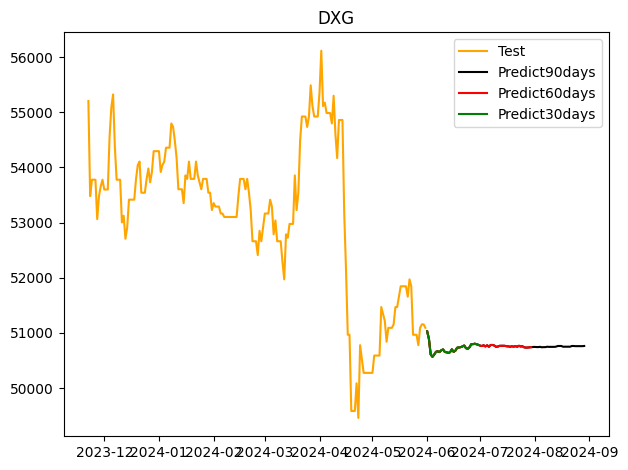

In [15]:
# 14.Vẽ hình
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# new = pd.date_range(start=dxg.index[0], end=dxg.index[dxg_train_size-1])
# plt.plot(new,scaler.inverse_transform(dxg_train_data))

new = pd.date_range(start=dxg.index[dxg_train_size], end=dxg.index[-1])
plt.plot(new,scaler.inverse_transform(dxg_test_data),color='orange')

start_date = dxg.index[-1] + datetime.timedelta(1)
dxg_predict_data_30 = pd.date_range(start=start_date, end=start_date + datetime.timedelta(29))
dxg_predict_data_60 = pd.date_range(start=start_date, end=start_date + datetime.timedelta(59))
dxg_predict_data_90 = pd.date_range(start=start_date, end=start_date + datetime.timedelta(89))
plt.plot(dxg_predict_data_90,scaler.inverse_transform(dxg_lst_output[:90]),color='black')
plt.plot(dxg_predict_data_60,scaler.inverse_transform(dxg_lst_output[:60]), color='red')
plt.plot(dxg_predict_data_30,scaler.inverse_transform(dxg_lst_output[:30]),color='green')
plt.legend(['Test','Predict90days','Predict60days','Predict30days'])
plt.title('DXG')
plt.tight_layout()
plt.show()

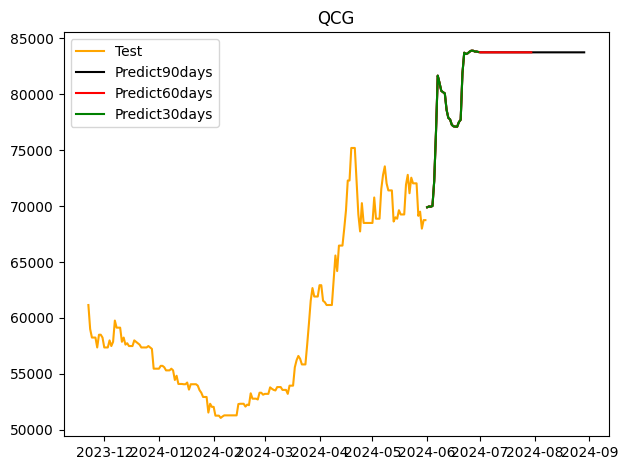

In [16]:
new = pd.date_range(start=qcg.index[qcg_train_size], end=qcg.index[-1])
plt.plot(new,scaler.inverse_transform(qcg_test_data),color='orange')

start_date = qcg.index[-1] + datetime.timedelta(1)
qcg_predict_data_30 = pd.date_range(start=start_date, end=start_date + datetime.timedelta(29))
qcg_predict_data_60 = pd.date_range(start=start_date, end=start_date + datetime.timedelta(59))
qcg_predict_data_90 = pd.date_range(start=start_date, end=start_date + datetime.timedelta(89))
plt.plot(qcg_predict_data_90,scaler.inverse_transform(qcg_lst_output[:90]),color='black')
plt.plot(qcg_predict_data_60,scaler.inverse_transform(qcg_lst_output[:60]), color='red')
plt.plot(qcg_predict_data_30,scaler.inverse_transform(qcg_lst_output[:30]),color='green')
plt.legend(['Test','Predict90days','Predict60days','Predict30days'])
plt.title('QCG')
plt.tight_layout()
plt.show()

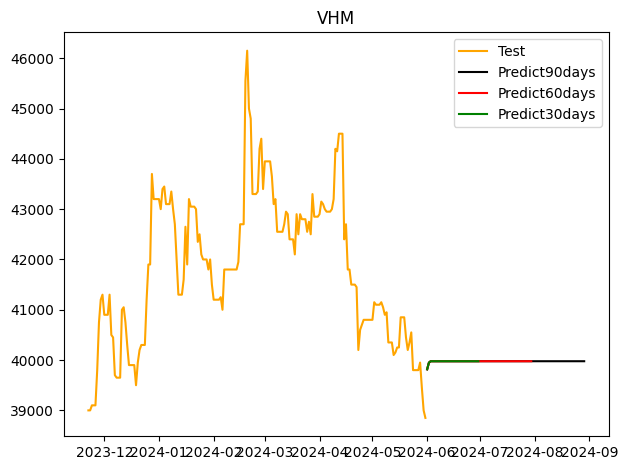

In [17]:
new = pd.date_range(start=vhm.index[vhm_train_size], end=vhm.index[-1])
plt.plot(new,scaler.inverse_transform(vhm_test_data),color='orange')

start_date = vhm.index[-1] + datetime.timedelta(1)
vhm_predict_data_30 = pd.date_range(start=start_date, end=start_date + datetime.timedelta(29))
vhm_predict_data_60 = pd.date_range(start=start_date, end=start_date + datetime.timedelta(59))
vhm_predict_data_90 = pd.date_range(start=start_date, end=start_date + datetime.timedelta(89))
plt.plot(vhm_predict_data_90,scaler.inverse_transform(vhm_lst_output[:90]),color='black')
plt.plot(vhm_predict_data_60,scaler.inverse_transform(vhm_lst_output[:60]), color='red')
plt.plot(vhm_predict_data_30,scaler.inverse_transform(vhm_lst_output[:30]),color='green')
plt.legend(['Test','Predict90days','Predict60days','Predict30days'])
plt.title('VHM')
plt.tight_layout()
plt.show()